In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from datetime import datetime, timedelta
pd.options.display.max_columns = 99

In [2]:
data = pd.read_csv('./data/byweek_lag.csv')
volatile = pd.read_csv('./data/volatile.csv')

In [3]:
data.head()

,week,CustomerIdx,IsinIdx,BuySell,CustomerInterest,TickerIdx,ActualMaturityDateKey,IssueDateKey,Seniority,Currency,ActivityGroup,Region_x,Activity,RiskCaptain,Owner,CompositeRating,IndustrySector,IndustrySubgroup,MarketIssue,IssuedAmount,CouponType,Sector,Subsector,Region_y,Country,Price,Yield,ZSpread
0,2015-12-28,10,312,Buy,0.0,3197,20280301,20171213,SEN,USD,FLOW G10,AMERICAS,CDS AND HY,CDS AND HY,US HY YANKEE,BB-,Communications,Cable/Satellite TV,Priv placement,1.000000e+09,FIXED,Corporation,Corp - Consumer Staples,Americas,USA,NaN,NaN,NaN
1,2015-12-28,10,316,Sell,0.0,3099,20201125,20131125,SEN,CAD,FLOW G10,AMERICAS,CDS AND HY,CDS AND HY,US HY FIN AUTOS,BBB+,Communications,Telephone-Integrated,Global,1.000000e+09,FIXED,Corporation,Corp - Consumer Staples,Americas,USA,NaN,NaN,NaN
2,2015-12-28,10,2686,Sell,0.0,722,20170619,20070619,SEN,USD,SAS & COVERED BONDS,USD SAS,USD SAS,USD SAS,USD SAS,AAA,Financial,Mortgage Banks,Euro mtn,1.000000e+09,FIXED,Corporation,Corp - Consumer Staples,Americas,USA,106.0530,1.3598,0.4164
3,2015-12-28,10,4305,Buy,0.0,24,20250728,20150728,SUB,USD,FLOW G10,AMERICAS,HG CASH,HG CASH FIN,YANKEES FIN LT2,BBB,Financial,Commer Banks Non-US,Priv placement,1.500000e+09,FIXED,Corporation,Corp - Consumer Staples,Americas,USA,100.1372,4.7316,2.7202
4,2015-12-28,10,4306,Sell,0.0,24,20170202,20120202,SEN,USD,FLOW G10,AMERICAS,HG CASH,HG CASH FIN,YANKEES FIN SHORT CASH,A,Financial,Money Center Banks,Priv placement,1.500000e+09,FIXED,Corporation,Corp - Consumer Staples,Americas,USA,102.8962,1.4870,0.6444


In [4]:
def convertDatetime(x):
    x = str(x)
    date = x[:4] + '-' + x[4:6] + '-' + x[6:]
    return datetime.strptime(date, '%Y-%m-%d')

In [5]:
combined = data.merge(volatile,how='left',on='IsinIdx')

In [6]:
def getMonths(x):
    maturity = str(x['ActualMaturityDateKey'])
    issue = str(x['IssueDateKey'])
    try:
        yeardiff = int(maturity[:4]) - int(issue[:4])
        monthdiff = int(maturity[4:6]) - int(issue[4:6])
        return yeardiff*12 + monthdiff
    except:
        return None

In [7]:
combined['ActualMaturityDateKey'] = combined['ActualMaturityDateKey'].apply(lambda x: convertDatetime(x))

In [8]:
combined['daysToMaturity'] = combined['ActualMaturityDateKey'] - combined['week'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [9]:
combined['daysToMaturity'] = combined['daysToMaturity'].apply(lambda x: int(x.days))

In [10]:
combined.head(3)

,week,CustomerIdx,IsinIdx,BuySell,CustomerInterest,TickerIdx,ActualMaturityDateKey,IssueDateKey,Seniority,Currency,ActivityGroup,Region_x,Activity,RiskCaptain,Owner,CompositeRating,IndustrySector,IndustrySubgroup,MarketIssue,IssuedAmount,CouponType,Sector,Subsector,Region_y,Country,Price,Yield,ZSpread,volrank,daysToMaturity
0,2015-12-28,10,312,Buy,0.0,3197,2028-03-01,20171213,SEN,USD,FLOW G10,AMERICAS,CDS AND HY,CDS AND HY,US HY YANKEE,BB-,Communications,Cable/Satellite TV,Priv placement,1.000000e+09,FIXED,Corporation,Corp - Consumer Staples,Americas,USA,NaN,NaN,NaN,low,4447
1,2015-12-28,10,316,Sell,0.0,3099,2020-11-25,20131125,SEN,CAD,FLOW G10,AMERICAS,CDS AND HY,CDS AND HY,US HY FIN AUTOS,BBB+,Communications,Telephone-Integrated,Global,1.000000e+09,FIXED,Corporation,Corp - Consumer Staples,Americas,USA,NaN,NaN,NaN,low,1794
2,2015-12-28,10,2686,Sell,0.0,722,2017-06-19,20070619,SEN,USD,SAS & COVERED BONDS,USD SAS,USD SAS,USD SAS,USD SAS,AAA,Financial,Mortgage Banks,Euro mtn,1.000000e+09,FIXED,Corporation,Corp - Consumer Staples,Americas,USA,106.053,1.3598,0.4164,low,539


In [11]:
combined['IssueDateKey'] = combined['IssueDateKey'].apply(lambda x: convertDatetime(x))
combined['daysSinceIssue'] = combined['week'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d')) - combined['IssueDateKey']
combined['daysSinceIssue'] = combined['daysSinceIssue'].apply(lambda x: int(x.days)) 

In [12]:
combined.columns

Index(['week', 'CustomerIdx', 'IsinIdx', 'BuySell', 'CustomerInterest',
       'TickerIdx', 'ActualMaturityDateKey', 'IssueDateKey', 'Seniority',
       'Currency', 'ActivityGroup', 'Region_x', 'Activity', 'RiskCaptain',
       'Owner', 'CompositeRating', 'IndustrySector', 'IndustrySubgroup',
       'MarketIssue', 'IssuedAmount', 'CouponType', 'Sector', 'Subsector',
       'Region_y', 'Country', 'Price', 'Yield', 'ZSpread', 'volrank',
       'daysToMaturity', 'daysSinceIssue'],
      dtype='object')

In [17]:
combined.CustomerInterest.value_counts()

0.0    4490010
1.0    1772720
Name: CustomerInterest, dtype: int64

In [18]:
combined.to_csv("train_test.csv",index=False)

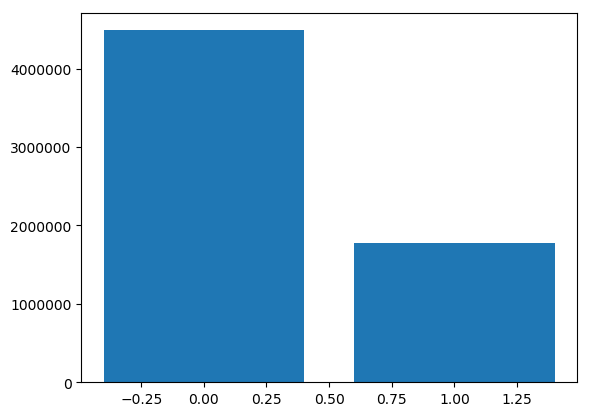

In [16]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

plt.bar(combined.CustomerInterest.unique(),combined.CustomerInterest.value_counts())
plt.show()

In [11]:
columns = ['week','CustomerIdx','IsinIdx','BuySell' ,'daysToMaturity','daysSinceIssue', 'Seniority', 'RiskCaptain'
           , 'CompositeRating', 'IndustrySector','MarketIssue', 'Sector', 'CouponType'
           ,'Country', 'Price', 'Yield', 'ZSpread', 'volrank', 'CustomerInterest']

In [12]:
features = ['BuySell' ,'daysToMaturity', 'Seniority','daysSinceIssue'
           , 'CompositeRating', 'IndustrySector','MarketIssue', 'Sector', 'CouponType',
           'Country', 'Price', 'Yield', 'ZSpread', 'volrank']

response = ['CustomerInterest']

In [13]:
df = combined[columns]

In [14]:
non_numeric_cols = ['BuySell', 'Seniority', 'CompositeRating', 'volrank','IndustrySector','MarketIssue', 'Sector', 'CouponType'
           ,'Country', 'volrank' ]

In [16]:
numeric_cols = ['daysToMaturity', 'daysSinceIssue', 'Price', 'Yield', 'ZSpread']

In [17]:
from sklearn.base import TransformerMixin
class DataFrameImputer(TransformerMixin):
    def fit(self, X, y=None):
        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].median() for c in X],
            index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.fill)

In [18]:
dfImputer = DataFrameImputer()

In [19]:
X, y = df[features], df['CustomerInterest']

In [20]:
X = dfImputer.fit_transform(X)

In [25]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler(quantile_range=(25, 75))
for feature in numeric_cols:
    X[feature] = scaler.fit_transform(np.array(X[feature]).reshape(-1,1))

In [27]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for feature in non_numeric_cols:
    X[feature] = le.fit_transform(X[feature])


In [32]:
X_train, X_test = X[X['week'] < '2017-11-01'][features], X[X['week'] >= '2017-11-01'][features]
y_train, y_test = y[y['week'] < '2017-11-01'][response], y[y['week'] >= '2017-11-01'][response]

In [33]:
gbm = xgb.XGBClassifier(objective="binary:logistic", max_depth=6, n_round=200 ,eval_metric="auc", learning_rate=0.05).fit(X_train.as_matrix(), y_train)

/Users/jinweitan/anaconda/lib/python3.5/site-packages/sklearn/preprocessing/label.py:112: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jinweitan/anaconda/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [34]:
ypred = gbm.predict_proba(X_test.as_matrix())
from sklearn import cross_validation, metrics
metrics.roc_auc_score(y_test['CustomerInterest'],  ypred[:,1])

/Users/jinweitan/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


0.81773568295736132

In [28]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import svm

In [29]:
X, y = X.as_matrix(), np.array(y)

/anaconda3/envs/kaggle/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [30]:
xgboost = xgb.XGBClassifier(objective="binary:logistic", 
                               max_depth=6, n_round=100 ,eval_metric="auc", learning_rate=0.01)

logistic = LogisticRegression()
gnb = GaussianNB()
svm = svm.SVC()

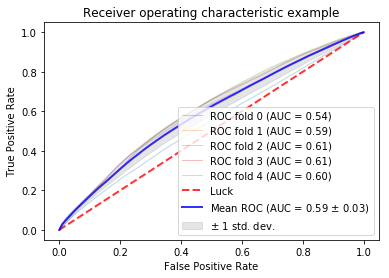

In [31]:
cv = StratifiedKFold(n_splits=5)
#classifier = xgb.XGBClassifier(objective="binary:logistic", 
#                               max_depth=6, n_round=100 ,eval_metric="auc", learning_rate=0.01)
classifier = xgboost
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X, y):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

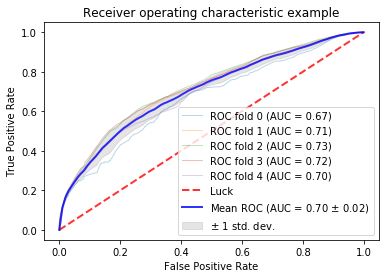

In [32]:
cv = StratifiedKFold(n_splits=5)
#classifier = xgb.XGBClassifier(objective="binary:logistic", 
#                               max_depth=6, n_round=100 ,eval_metric="auc", learning_rate=0.01)
classifier1 = xgboost
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X, y):
    probas_ = classifier1.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [122]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.33, random_state=42)

In [86]:
y_train, y_test = np.array(y_train), np.array(y_test)

In [87]:
gbm = xgb.XGBClassifier(objective="binary:logistic", max_depth=6, n_round=200 ,eval_metric="auc", learning_rate=0.05).fit(X_train.as_matrix(), y_train)

In [114]:
# Gridsearch CV
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV 

def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain['CustomerInterest'].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=True)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['CustomerInterest'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(dtrain['CustomerInterest'].values, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['CustomerInterest'], dtrain_predprob)
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [105]:
features_noidx = ['BuySell', 'monthsToMaturity', 'Seniority'
           , 'CompositeRating', 'IndustrySector','IssuedAmount', 'CouponType','volrank']

In [141]:
model =  xgb.XGBClassifier(
 learning_rate =0.05,
 n_estimators=500,
 max_depth=6,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
)


In [131]:
dtrain =  pd.concat([X_train, y_train], axis=1, join_axes=[X_train.index])

In [132]:
dtrain.head()

,CustomerIdx,IsinIdxleft,BuySell,monthsToMaturity,Seniority,CompositeRating,IndustrySector,IssuedAmount,CouponType,volrank,CustomerInterest
3703815,1929,26561,1,96.0,5,28,7,750000000.0,0,0,0.0
3108448,1280,22737,0,96.0,5,28,7,750000000.0,0,0,0.0
246443,1486,20917,0,96.0,5,28,7,750000000.0,0,0,1.0
2641536,689,22532,0,96.0,5,28,7,750000000.0,0,0,0.0
3790759,1967,25124,1,96.0,5,28,7,750000000.0,0,0,0.0


In [142]:
modelfit(model, dtrain, features_noidx)

[0]	train-auc:0.510996+7.09789e-05	test-auc:0.510995+0.000282714
[1]	train-auc:0.511006+7.02868e-05	test-auc:0.511005+0.000285292
[2]	train-auc:0.511006+7.04142e-05	test-auc:0.511006+0.00028474
[3]	train-auc:0.511007+7.05634e-05	test-auc:0.511007+0.000284736
[4]	train-auc:0.511007+7.09073e-05	test-auc:0.511008+0.000284203
[5]	train-auc:0.511007+7.09073e-05	test-auc:0.511008+0.000284203
[6]	train-auc:0.511007+7.09073e-05	test-auc:0.511008+0.000284203
[7]	train-auc:0.511007+7.09073e-05	test-auc:0.511008+0.000284203
[8]	train-auc:0.511007+7.09073e-05	test-auc:0.511008+0.000284203
[9]	train-auc:0.511007+7.09073e-05	test-auc:0.511008+0.000284203
[10]	train-auc:0.511007+7.09073e-05	test-auc:0.511008+0.000284203
[11]	train-auc:0.511007+7.09073e-05	test-auc:0.511008+0.000284203
[12]	train-auc:0.511007+7.09073e-05	test-auc:0.511008+0.000284203
[13]	train-auc:0.511007+7.09073e-05	test-auc:0.511008+0.000284203
[14]	train-auc:0.511007+7.09073e-05	test-auc:0.511008+0.000284203
[15]	train-auc:0.5110

TypeError: 'str' object is not callable

array([ 0.4595885 ,  0.4595885 ,  0.46115202, ...,  0.46115202,
        0.4595885 ,  0.46115202], dtype=float32)

In [146]:
metrics.roc_auc_score(y_test['CustomerInterest'],  model.predict_proba(X_test[features_noidx])[:,1])

0.51039018125382885

In [88]:
ypred = gbm.predict_proba(X_test.as_matrix())

In [89]:
ypred

array([[ 0.66675603,  0.33324394],
       [ 0.71622753,  0.28377244],
       [ 0.57226062,  0.42773935],
       ..., 
       [ 0.83804631,  0.16195369],
       [ 0.67152441,  0.32847562],
       [ 0.43141991,  0.56858009]], dtype=float32)

In [39]:
y_test2 = [np.insert(i,0,1-i[0],axis=0) for i in y_test]

In [90]:
y_test

array([[ 1.],
       [ 0.],
       [ 1.],
       ..., 
       [ 0.],
       [ 0.],
       [ 0.]])

In [96]:
y_test = np.array(y_test[['other','CustomerInterest']])

In [91]:
ypred[:,1]

array([ 0.33324394,  0.28377244,  0.42773935, ...,  0.16195369,
        0.32847562,  0.56858009], dtype=float32)

In [51]:
y_test = y_test.flatten()

In [52]:
y_test

array([ 1.,  0.,  1., ...,  0.,  0.,  0.])

In [53]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, ypred[:,1], pos_label=2)


In [54]:
fpr, tpr, thresholds

(array([ 0.        ,  0.21887574,  0.32698176,  1.        ]),
 array([ nan,  nan,  nan,  nan]),
 array([ 1.9966886 ,  0.99668854,  0.99668759,  0.00331077], dtype=float32))

In [37]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], ypred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


IndexError: index 1 is out of bounds for axis 1 with size 1

In [100]:
roc_auc

{0: 1.0, 1: 1.0}

In [1]:
from scipy import interp
import matplotlib.pyplot as plt
# Compute macro-average ROC curve and ROC area
n_classes=2
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

NameError: name 'np' is not defined

## Submission

In [60]:
challenge = pd.read_csv('./data/Challenge_20180423.csv')
challenge.sort_values('PredictionIdx',inplace=True)

In [61]:
customer = pd.read_csv('./data/Customer.csv')
isin = pd.read_csv('./data/Isin.csv')

In [62]:
one = challenge.merge(isin, on ='IsinIdx', how='left')
two = one.merge(customer, on='CustomerIdx', how='left')

In [63]:
two = two.merge(volatile,how='left',on='IsinIdx')

In [106]:
market = pd.read_csv('./data/Market.csv')
def convertDatetime(x):
    x = str(x)
    date = x[:4] + '-' + x[4:6] + '-' + x[6:]
    return datetime.strptime(date, '%Y-%m-%d')

In [107]:
market['date'] = market['DateKey'].apply(lambda x: convertDatetime(x))
market['week'] = market['date'].apply(lambda x: x - timedelta(days=x.weekday()))
marketbyweek = market.drop(['DateKey','date'], axis=1)
marketgrouped = marketbyweek.groupby(by=['week','IsinIdx'])['Price','Yield','ZSpread'].mean().reset_index()

In [108]:
marketgrouped[]

,week,IsinIdx,Price,Yield,ZSpread
0,2015-12-28,1,104.250,7.835,5.505
1,2015-12-28,7,107.500,7.520,5.541
2,2015-12-28,102,100.746,4.048,2.085
3,2015-12-28,156,98.065,3.984,2.136
4,2015-12-28,331,112.790,-0.752,-0.215


In [109]:
market_small = marketgrouped[marketgrouped['week'] >= '2018-04-16']
market_small['week'] = datetime.strptime('2018-04-23', '%Y-%m-%d')

In [111]:
two['week'] = two['DateKey'].apply(lambda x: convertDatetime(x))

In [118]:
combined = two.merge(market_small, how='left', on=['week','IsinIdx'])

In [119]:
combined.head()

,PredictionIdx,DateKey,CustomerIdx,IsinIdx,BuySell,CustomerInterest,TickerIdx,ActualMaturityDateKey,IssueDateKey,Seniority,Currency,ActivityGroup,Region_x,Activity,RiskCaptain,Owner,CompositeRating,IndustrySector,IndustrySubgroup,MarketIssue,IssuedAmount,CouponType,Sector,Subsector,Region_y,Country,volrank,week,Price,Yield,ZSpread
0,00000aa6c4,20180423,1822,24530,Sell,NaN,3184,20260414,20160414,SEN,EUR,FLOW G10,EUROPE,INSTITUTIONAL MARKET MAKING,HIGH GRADE CORP,TMT/AUTO CASH & PERPS,A,Communications,Cellular Telecom,Euro mtn,7.500000e+08,FIXED,Asset Managers & Hedge Funds,Asset Mgr owned by Bank/Insur.,"Europe, Middle East and Africa",ITALY,low,2018-04-23,99.9678,1.1288,0.3744
1,00000feadb,20180423,2792,2981,Buy,NaN,530,20191129,20121130,SEC,EUR,SAS & COVERED BONDS,EUR COVERED,EUR COVERED,EUR COVERED,EUR COVERED,AAA,Financial,Finance-Mtge Loan/Banker,Euro-zone,1.000000e+09,FIXED,Banks and Intermediaries,Bank,"Europe, Middle East and Africa",GERMANY,low,2018-04-23,103.3630,-0.3312,-0.1280
2,00003569b7,20180423,222,21439,Buy,NaN,1220,20230806,20130806,SEN,USD,FLOW LOCAL MARKET,EUROPE,LOCAL MARKET,LOCAL MARKET,EUROPE LM SK,CCC+,Utilities,Electric-Integrated,Euro mtn,1.000000e+09,FIXED,Asset Managers & Hedge Funds,Asset Mgr owned by Bank/Insur.,"Europe, Middle East and Africa",SWITZERLAND,low,2018-04-23,101.7500,6.3528,3.4998
3,00005bb063,20180423,1788,23643,Buy,NaN,3334,20230522,20150522,SEN,EUR,FLOW G10,EUROPE,INSTITUTIONAL MARKET MAKING,HIGH GRADE CORP,INDUSTRIALS/MINERS/CHEMS/PHARM,A-,Industrial,Aerospace/Defense-Equip,Euro non-dollar,7.500000e+08,FIXED,Banks and Intermediaries,Private Bank - Wealth Manager,"Europe, Middle East and Africa",SWITZERLAND,low,2018-04-23,102.9570,0.6280,0.2740
4,0000681f81,20180423,222,20742,Sell,NaN,1524,20230630,20121120,SUB,EUR,FLOW G10,EUROPE,INSTITUTIONAL MARKET MAKING,FINANCIALS,INSCO CASH,NR,Financial,Reinsurance,Euro-zone,5.000000e+08,VARIABLE,Asset Managers & Hedge Funds,Asset Mgr owned by Bank/Insur.,"Europe, Middle East and Africa",SWITZERLAND,low,2018-04-23,118.5594,1.2818,0.8982


In [120]:
combined['ActualMaturityDateKey'] = combined['ActualMaturityDateKey'].apply(lambda x: convertDatetime(x))
combined['week'] = combined['DateKey'].apply(lambda x: convertDatetime(x))
combined['daysToMaturity'] = combined['ActualMaturityDateKey'] - combined['week']
combined['daysToMaturity'] = combined['daysToMaturity'].apply(lambda x: int(x.days))

In [121]:
combined['IssueDateKey'] = combined['IssueDateKey'].apply(lambda x: convertDatetime(x))
combined['daysSinceIssue'] = combined['week'] - combined['IssueDateKey']
combined['daysSinceIssue'] = combined['daysSinceIssue'].apply(lambda x: int(x.days)) 

In [122]:
combined.head()

,PredictionIdx,DateKey,CustomerIdx,IsinIdx,BuySell,CustomerInterest,TickerIdx,ActualMaturityDateKey,IssueDateKey,Seniority,Currency,ActivityGroup,Region_x,Activity,RiskCaptain,Owner,CompositeRating,IndustrySector,IndustrySubgroup,MarketIssue,IssuedAmount,CouponType,Sector,Subsector,Region_y,Country,volrank,week,Price,Yield,ZSpread,daysToMaturity,daysSinceIssue
0,00000aa6c4,20180423,1822,24530,Sell,NaN,3184,2026-04-14,2016-04-14,SEN,EUR,FLOW G10,EUROPE,INSTITUTIONAL MARKET MAKING,HIGH GRADE CORP,TMT/AUTO CASH & PERPS,A,Communications,Cellular Telecom,Euro mtn,7.500000e+08,FIXED,Asset Managers & Hedge Funds,Asset Mgr owned by Bank/Insur.,"Europe, Middle East and Africa",ITALY,low,2018-04-23,99.9678,1.1288,0.3744,2913,739
1,00000feadb,20180423,2792,2981,Buy,NaN,530,2019-11-29,2012-11-30,SEC,EUR,SAS & COVERED BONDS,EUR COVERED,EUR COVERED,EUR COVERED,EUR COVERED,AAA,Financial,Finance-Mtge Loan/Banker,Euro-zone,1.000000e+09,FIXED,Banks and Intermediaries,Bank,"Europe, Middle East and Africa",GERMANY,low,2018-04-23,103.3630,-0.3312,-0.1280,585,1970
2,00003569b7,20180423,222,21439,Buy,NaN,1220,2023-08-06,2013-08-06,SEN,USD,FLOW LOCAL MARKET,EUROPE,LOCAL MARKET,LOCAL MARKET,EUROPE LM SK,CCC+,Utilities,Electric-Integrated,Euro mtn,1.000000e+09,FIXED,Asset Managers & Hedge Funds,Asset Mgr owned by Bank/Insur.,"Europe, Middle East and Africa",SWITZERLAND,low,2018-04-23,101.7500,6.3528,3.4998,1931,1721
3,00005bb063,20180423,1788,23643,Buy,NaN,3334,2023-05-22,2015-05-22,SEN,EUR,FLOW G10,EUROPE,INSTITUTIONAL MARKET MAKING,HIGH GRADE CORP,INDUSTRIALS/MINERS/CHEMS/PHARM,A-,Industrial,Aerospace/Defense-Equip,Euro non-dollar,7.500000e+08,FIXED,Banks and Intermediaries,Private Bank - Wealth Manager,"Europe, Middle East and Africa",SWITZERLAND,low,2018-04-23,102.9570,0.6280,0.2740,1855,1067
4,0000681f81,20180423,222,20742,Sell,NaN,1524,2023-06-30,2012-11-20,SUB,EUR,FLOW G10,EUROPE,INSTITUTIONAL MARKET MAKING,FINANCIALS,INSCO CASH,NR,Financial,Reinsurance,Euro-zone,5.000000e+08,VARIABLE,Asset Managers & Hedge Funds,Asset Mgr owned by Bank/Insur.,"Europe, Middle East and Africa",SWITZERLAND,low,2018-04-23,118.5594,1.2818,0.8982,1894,1980


In [123]:
challenge_data = combined[columns]

In [124]:
challenge_X = challenge_data[features]

In [125]:
challenge_X = dfImputer.fit_transform(challenge_X)

In [126]:
for feature in non_numeric_cols:
    challenge_X[feature] = le.fit_transform(challenge_X[feature])

In [140]:
result = classifier.predict_proba(challenge_X.as_matrix())[:,1]

/anaconda3/envs/kaggle/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [141]:
result

array([0.30939306, 0.29773309, 0.285943  , ..., 0.30979961, 0.27922545,
       0.29071595])

In [129]:
submission = pd.read_csv('./data/sample_submission.csv')

In [130]:
submission.sort_values('PredictionIdx',inplace=True)

In [131]:
submission['CustomerInterest'] = result

In [132]:
submission.to_csv('0614_2.csv',index=False)